In [33]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *
import      configparser

inputs = configparser.ConfigParser()


#path dove stanno i dati del fit

spectra_filename    =   'ARS_13_02'


analysis_dir = 'analysis_new_master_better'


spectra_path = '../BRILLOUIN/TDP43/'+spectra_filename+'/'
now_path = spectra_path+analysis_dir+'/'


with open(now_path+'config.ini', 'r') as f:
    inputs.read_file(f)
### recupero info su dimensionalità
n_rows    =     inputs.getint('I/O', 'n_rows')
n_cols    =     inputs.getint('I/O', 'n_cols')
###
matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)

Ho inizializzato una matrice 85x89, per un totale di 7565 spettri


In [34]:

#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

with open(now_path+'xy.txt', 'r') as fin:
    lines = fin.readlines()[1:]

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

"""
x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)


for (ii,jj) in boni:
    matrix[ii][jj].Recover_VIPA(x_VIPA, y_VIPA)
"""

count = 0
for (ii,jj) in serpentine_range(n_rows, n_cols, 'right'):
        matrix[ii][jj].Recover_Spectrum(np.array(lines[count][1:-2].split(), dtype=float), np.array(lines[count+1][1:-2].split(), dtype=float))
        
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)

        count = count + 2

print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [35]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni parametri fit ({})".format(len(boni), len(lines)))
if (len(boni) != len(costi)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni costo fit ({})".format(len(boni), len(costi)))
if (len(boni) != len(y_fits)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e y fit ({})".format(len(boni), len(y_fits)))


for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')




Ok ho recuperato le informazioni del Fit Markoviano


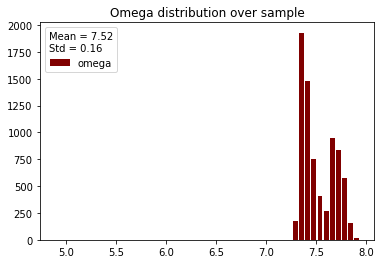

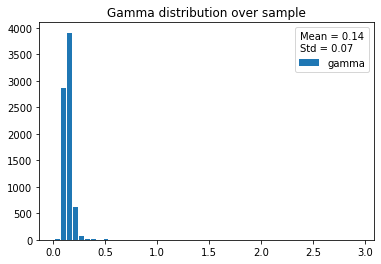

In [36]:
#HISTOGRAMs - MARKOV
markov_Omegas = np.array([matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
markov_Gammas =  np.array([matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])


plt.figure()
plt.title('Omega distribution over sample')
_ = plt.hist(markov_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(markov_Omegas), np.std(markov_Omegas)))
plt.savefig(now_path+'Omega_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample')
_ = plt.hist(markov_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(markov_Gammas), np.std(markov_Gammas)))
plt.savefig(now_path+'Gamma_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()


In [37]:
#Parametri di Interesse per analisi
markov_too_bad = ()
markov_too_good  = ()
markov_omega_too_high =  ()
markov_gamma_too_bad = ()

markov_omega_max = np.mean(markov_Omegas)+5*np.std(markov_Omegas)
markov_gamma_max = np.mean(markov_Gammas)+5*np.std(markov_Gammas)
cost_max = 1000
cost_min = 50


markov_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'markov')
markov_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'markov')
markov_omega_too_high = Whose_Param_Too_High('Omega', markov_omega_max, 'markov', matrix, boni)
markov_gamma_too_high = Whose_Param_Too_High('Gamma', markov_gamma_max, 'markov', matrix, boni)


#aggiunte 
markov_too_offset = ()
percentage_gamma = 15
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    if matrix[ii][jj].Markov_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Markov_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        markov_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Markov_Fit_Params['offset'].values[0] > max_offset:
        markov_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        markov_almost_height += ((ii,jj),)


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(markov_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(markov_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(markov_omega_too_high), markov_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(markov_gamma_too_high), markov_gamma_max))

print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(markov_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(markov_too_offset), max_offset))





I found 3 bad elements out of 7550

I found 5657 good elements out of 7550

(2, 32) ha Gamma= 0.53
(3, 33) ha Gamma= 0.78
(3, 36) ha Gamma= 2.60
(3, 37) ha Gamma= 2.95
(20, 39) ha Gamma= 1.74
(24, 42) ha Gamma= 0.51
(24, 34) ha Gamma= 0.51
(24, 33) ha Gamma= 0.51
(24, 28) ha Gamma= 0.50
(30, 38) ha Gamma= 0.87
(33, 38) ha Gamma= 0.48
(34, 40) ha Gamma= 0.63
(34, 39) ha Gamma= 0.59
(34, 38) ha Gamma= 0.58
(35, 38) ha Gamma= 0.64
(36, 46) ha Gamma= 0.64
(41, 52) ha Gamma= 0.73
(42, 50) ha Gamma= 0.60
(44, 50) ha Gamma= 0.96
(46, 51) ha Gamma= 1.93




Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/ARS_13_02/analysis_new_master_better/ :

3 elementi con chi quadro > 1000 
5657 elementi con chi quadro < 50 

0 elementi con Omega > Omega max 8.34
20 elementi con Gamma > Gamma max 0.48

502 elementi con Gamma con errore percentuale > 15 

20 elementi con offset > 30 



Completata Parameter_Map per Omega
Ho trovato 15 elementi saturati


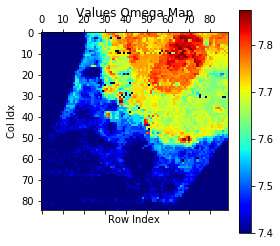

Completata Parameter_Map per Omega
Ho trovato 15 elementi saturati


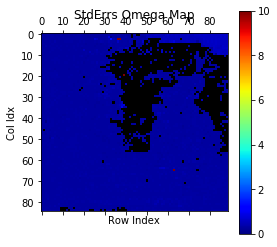

Completata Parameter_Map per Gamma
Ho trovato 15 elementi saturati


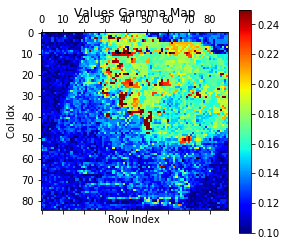

Completata Parameter_Map per Gamma
Ho trovato 15 elementi saturati


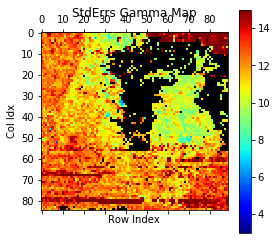

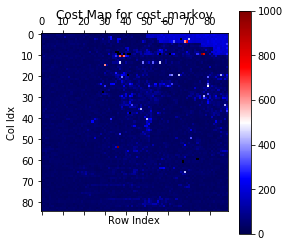

In [42]:
#MAPPE
omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.4, 7.875, fig = 'omega_markov_map', path=now_path)
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,10, fig = 'Delta_omega_markov_map', path=now_path, Deltas = True)
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.25, fig = 'Gamma_markov_map', path=now_path)
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 3, 15, fig = 'Delta_Gamma_markov_map', path=now_path, Deltas = True)
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)

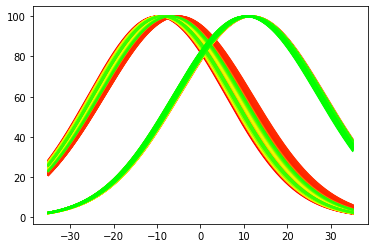

In [44]:
from colorsys import hsv_to_rgb
def get_color(red_to_green):
    assert 0 <= red_to_green <= 1
    # in HSV, red is 0 deg and green is 120 deg (out of 360);
    # divide red_to_green with 3 to map [0, 1] to [0, 1./3.]
    hue = red_to_green / 3.0
    r, g, b = hsv_to_rgb(hue, 1, 1)
    return r,g,b
x = np.linspace(-35,35, 1000)
f, ax = plt.subplots()
t_range = boni[:1000]
for (ii,jj), kk in zip(t_range, range(len(t_range))):
    rgb =  get_color(kk/(len(t_range)-1))
    ax.plot(x, gaussian(x, 100, *matrix[ii][jj].Markov_Fit_Params[['mu', 'sigma']].values[0]), c = rgb)


(25, 5)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.716174  7.479076  0.195766       -0.104434     0.033945   
StdErrs   0.047875  0.020665  0.013987        0.020456     0.001222   
Initials  0.100000  7.786541  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           1.511278  6.999325e+02  10.640410  14.284054  0.256336   
StdErrs          0.062823  5.580793e+08   0.828462   0.961237  0.020522   
Initials         0.100000  6.226355e+02  10.851784  16.706945  0.000000   

            offset  
Values   -4.245076  
StdErrs   0.449360  
Initials  0.000000  


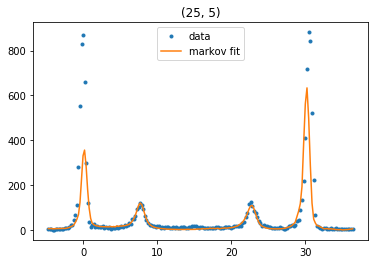

(25, 6)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.658765  7.457085  0.167167       -0.290480     0.061021   
StdErrs   0.039965  0.019856  0.012761        0.020073     0.006798   
Initials  0.100000  7.786541  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           1.060180  5.610056e+02  11.089975  13.421860  0.456698   
StdErrs          0.075559  4.544097e+08   0.656503   0.716477  0.019797   
Initials         0.100000  6.226355e+02  10.851784  16.706945  0.000000   

            offset  
Values   -2.754715  
StdErrs   0.364819  
Initials  0.000000  


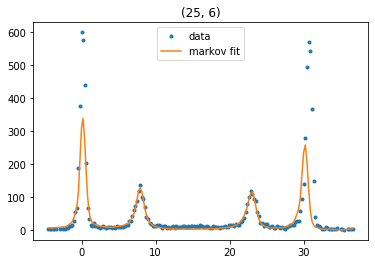

(25, 7)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    1.069425  7.485583  0.236717       -0.091158     0.036616   
StdErrs   0.045458  0.021168  0.015815        0.020696     0.000452   
Initials  0.100000  7.786541  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           7.527336  7.447062e+02   8.981031  20.048334  0.442412   
StdErrs          0.105405  2.483582e+08   1.455773   1.443275  0.020743   
Initials         0.100000  6.226355e+02  10.851784  16.706945  0.000000   

             offset  
Values   -14.315307  
StdErrs    0.718840  
Initials   0.000000  


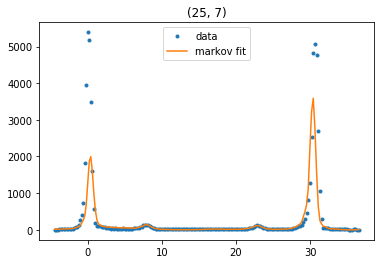

(25, 8)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.652035  7.480543  0.154138        0.338185     0.016605   
StdErrs   0.046452  0.020413  0.014100        0.020373     0.000300   
Initials  0.100000  7.786541  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           2.489776  7.179311e+02   9.912277  14.293945  0.228622   
StdErrs          0.028171  3.880257e+08   0.999206   1.023722  0.020372   
Initials         0.100000  6.226355e+02  10.851784  16.706945  0.000000   

            offset  
Values   -1.224329  
StdErrs   0.440300  
Initials  0.000000  


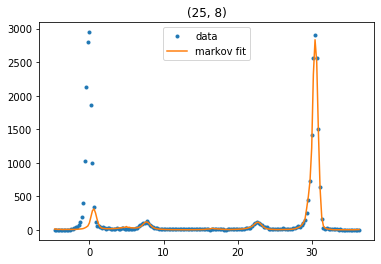

(25, 9)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    1.101063  7.504839  0.269721        0.007037     0.035697   
StdErrs   0.043925  0.022612  0.016691        0.021806     0.000420   
Initials  0.100000  7.786541  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           8.031051  7.468840e+02  11.461676  20.048334  0.138618   
StdErrs          0.101835  2.227993e+08   1.206133   1.268293  0.021835   
Initials         0.100000  6.226355e+02  10.851784  16.706945  0.000000   

             offset  
Values   -17.211514  
StdErrs    0.713301  
Initials   0.000000  


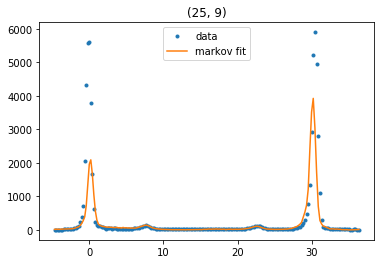

(25, 10)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.887179  7.478999  0.210737       -0.055586     0.039106   
StdErrs   0.040129  0.020890  0.014901        0.020502     0.000708   
Initials  0.100000  7.786541  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           4.204728  6.261048e+02   8.925972  17.698185  0.409408   
StdErrs          0.083205  2.394258e+08   1.237701   1.102661  0.020563   
Initials         0.100000  6.226355e+02  10.851784  16.706945  0.000000   

            offset  
Values   -9.054928  
StdErrs   0.570472  
Initials  0.000000  


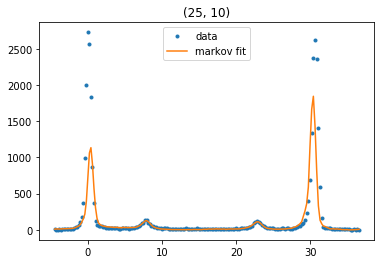

(25, 11)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.609632  7.415379  0.171516       -0.321354     0.033183   
StdErrs   0.037218  0.020839  0.013463        0.020929     0.002495   
Initials  0.100000  7.786541  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.340797  5.990844e+02  10.596887  13.365556  0.389821   
StdErrs          0.021245  5.652151e+08   0.726923   0.708623  0.020873   
Initials         0.100000  6.226355e+02  10.851784  16.706945  0.000000   

            offset  
Values   -0.234634  
StdErrs   0.349881  
Initials  0.000000  


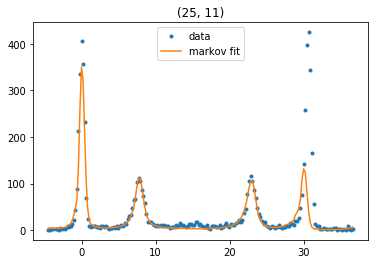

(25, 12)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.616896  7.433894  0.188270       -0.268663     0.035060   
StdErrs   0.036668  0.021439  0.013817        0.021345     0.002869   
Initials  0.100000  7.786541  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.667646  5.820739e+02  11.252006  13.365556  0.415233   
StdErrs          0.062838  5.820009e+08   0.662802   0.679017  0.021432   
Initials         0.100000  6.226355e+02  10.851784  16.706945  0.000000   

            offset  
Values   -1.781836  
StdErrs   0.362235  
Initials  0.000000  


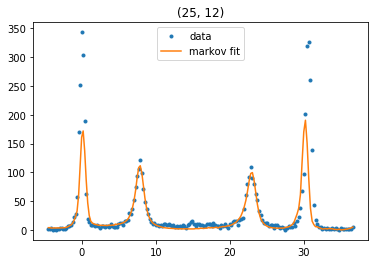

(25, 13)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.584030  7.484532  0.182012       -0.281158     0.024085   
StdErrs   0.025372  0.022381  0.014238        0.022467     0.002155   
Initials  0.100000  7.786541  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.705322  6.608913e+02   8.681427  13.365556  0.444584   
StdErrs          0.066694  7.584012e+08   0.861473   0.523233  0.022595   
Initials         0.100000  6.226355e+02  10.851784  16.706945  0.000000   

            offset  
Values   -1.987053  
StdErrs   0.274242  
Initials  0.000000  


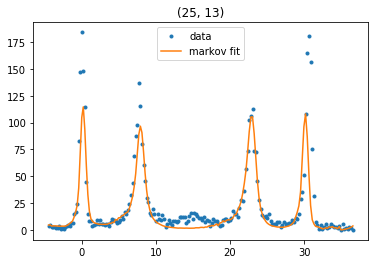

(25, 14)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.655834  7.411445  0.197733       -0.051504     0.027535   
StdErrs   0.038523  0.021526  0.014505        0.021364     0.000834   
Initials  0.100000  7.786541  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           1.477123  5.614021e+02   9.722381  13.365556  0.404084   
StdErrs          0.055328  3.653856e+08   0.768343   0.663186  0.021469   
Initials         0.100000  6.226355e+02  10.851784  16.706945  0.000000   

            offset  
Values   -2.469357  
StdErrs   0.418979  
Initials  0.000000  


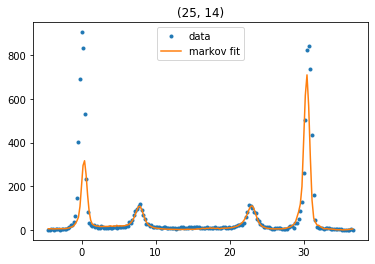

In [17]:
Plot_Elements_Spectrum(matrix, boni[2130:2140], fit = 'markov' )

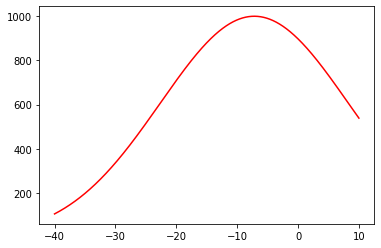

mu      sigma
Values    -7.184732  15.447074
StdErrs   31.913324  30.506826
Initials  -7.113596  15.431642

In [12]:
plt.figure()
x = np.linspace(-40, 10, 5000)
for (ii,jj) in boni[-1:]:
    plt.plot(x, gaussian(x, 1000, *matrix[ii][jj].Markov_Fit_Params[list(cols_gauss)].values[0][1:]), c = 'r')
    plt.show()
matrix[ii][jj].Markov_Fit_Params[['mu', 'sigma']]


In [13]:
################ TOTALE

with open(now_path+'y_tot_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    matrix[ii][jj].Recover_y_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

Ok ho recuperato le informazioni del Fit Totale


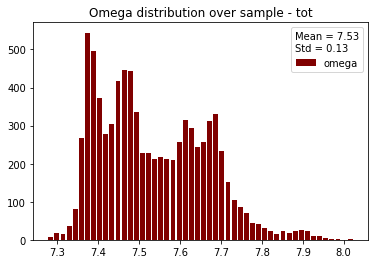

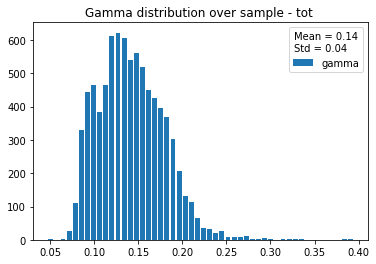

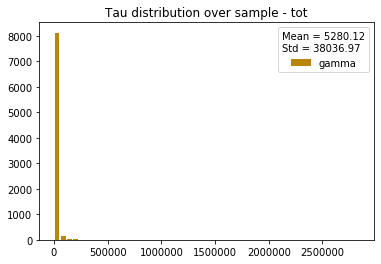

In [42]:
#HISTOGRAMs
tot_Omegas = np.array([matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
tot_Gammas =  np.array([matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])
taus       = np.array([matrix[ii][jj].Tot_Fit_Params['tau'].values[0] for (ii,jj) in boni])

plt.figure()
plt.title('Omega distribution over sample - tot')
_ = plt.hist(tot_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(tot_Omegas), np.std(tot_Omegas)))
plt.savefig(now_path+'Omega_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample - tot ')
_ = plt.hist(tot_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(tot_Gammas), np.std(tot_Gammas)))
plt.savefig(now_path+'Gamma_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Tau distribution over sample - tot')
_ = plt.hist(taus, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8, color = 'darkgoldenrod')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(taus), np.std(taus)))
plt.savefig(now_path+'tau_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()


In [53]:
#Parametri di Interesse per analisi
tot_too_bad = ()
tot_too_good  = ()
tot_omega_too_high =  ()
tot_gamma_too_bad = ()
tau_not_bad = []

tot_omega_max = np.mean(tot_Omegas)+5*np.std(tot_Omegas)
tot_gamma_max = np.mean(tot_Gammas)+5*np.std(tot_Gammas)
cost_max = 1000
cost_min = 50


tot_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'tot')
tot_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'tot')
tot_omega_too_high = Whose_Param_Too_High('Omega', tot_omega_max, 'markov', matrix, boni)
tot_gamma_too_high = Whose_Param_Too_High('Gamma', tot_gamma_max, 'markov', matrix, boni)


#aggiunte 
omega_different_from_mark = []
gamma_different_from_mark = []

percentage_diff = 0.8
tot_too_offset = ()
percentage_gamma = 100
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    
    perc_omega = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100
    perc_gamma = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100

    if (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] > matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] < matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] - perc_gamma):
        omega_different_from_mark.append((ii,jj))
    if (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] > matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] < matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] - perc_omega):
        gamma_different_from_mark.append((ii,jj))
    if matrix[ii][jj].Tot_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Tot_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        tot_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['offset'].values[0] > max_offset:
        tot_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        tot_almost_height += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['tau']['StdErrs'] < matrix[ii][jj].Tot_Fit_Params['tau']['Values']:
        tau_not_bad.append((ii,jj))


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(tot_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(tot_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(tot_omega_too_high), tot_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(tot_gamma_too_high), tot_gamma_max))


print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(markov_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(too_offset), max_offset))

print('{} elementi il cui fit tot di Omega è diverso del {} percento da markoviano'.format(len(omega_different_from_mark), percentage_diff))
print('{} elementi il cui fit tot di Gamma è diverso del {} percento da markoviano'.format(len(gamma_different_from_mark), percentage_diff))
print('{} elementi il cui fit di tau non è cosi male..'.format(len(tau_not_bad)), tau_not_bad)


I found 9 bad elements out of 8317

I found 3572 good elements out of 8317

(68, 24) ha Gamma= 0.39
(69, 66) ha Gamma= 0.34
(69, 68) ha Gamma= 0.34
(70, 45) ha Gamma= 0.38
(71, 24) ha Gamma= 0.39
(78, 26) ha Gamma= 0.40
(82, 35) ha Gamma= 0.33




Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/NO_ARS_12_02/analysis/ :

9 elementi con chi quadro > 1000 
3572 elementi con chi quadro < 50 

0 elementi con Omega > Omega max 8.18
7 elementi con Gamma > Gamma max 0.33

1314 elementi con Gamma con errore percentuale > 100 

0 elementi con offset > 30 

6851 elementi il cui fit tot di Omega è diverso del 0.8 percento da markoviano
0 elementi il cui fit tot di Gamma è diverso del 0.8 percento da markoviano
4 elementi il cui fit di tau non è cosi male.. [(40, 76), (55, 35), (56, 37), (73, 52)]


(40, 76)
                Co     Omega     Gamma      Delta       tau  delta_position  \
Values    0.121118  7.597234  0.140535  46.504229  0.352776       -1.306459   
StdErrs   0.006732  0.101374  0.136881   7.005520  0.055209        0.049083   
Initials  0.100932  7.673974  0.139143   0.139143  1.000000        1.497096   

          delta_width  delta_amplitude     shift     offset  
Values       1.927876         0.003110  3.178711 -29.951370  
StdErrs      0.024070         0.000049  0.049086   1.976993  
Initials     1.947349         0.003079  0.370169   9.345889  


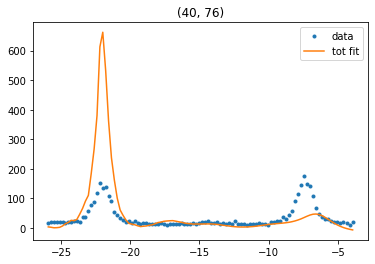

(55, 35)
                Co     Omega     Gamma     Delta       tau  delta_position  \
Values    0.126977  7.841040  0.151596  1.329075  0.187231       -0.953126   
StdErrs   0.016183  0.533183  0.193697  1.079040  0.149536        0.024172   
Initials  0.105826  7.764344  0.152495  0.152495  1.000000       -1.092358   

          delta_width  delta_amplitude     shift      offset  
Values       2.285461         0.000448  0.101128 -101.234881  
StdErrs      0.005380         0.000002  0.024172    2.108611  
Initials     2.308546         0.000443  0.240191    7.533263  


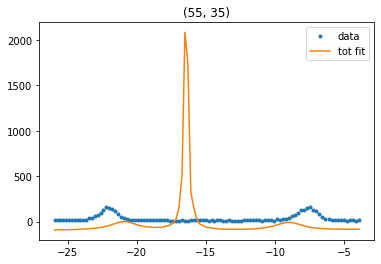

(56, 37)
                Co     Omega     Gamma      Delta       tau  delta_position  \
Values    0.122793  7.852515  0.150517  48.034950  2.992578       -1.992852   
StdErrs   0.003141  0.210306  0.042498  47.716383  2.831134        0.007243   
Initials  0.102327  7.774768  0.149228   0.149228  1.000000       -1.999833   

          delta_width  delta_amplitude     shift      offset  
Values       0.979882         0.000549  0.223549 -229.246867  
StdErrs      0.000746         0.000002  0.007243    0.799971  
Initials     0.989780         0.000554  0.230493    6.482707  


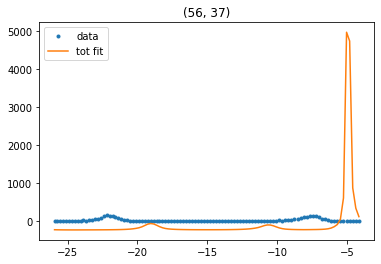

(73, 52)
                Co     Omega     Gamma      Delta       tau  delta_position  \
Values    0.122358  7.744938  0.177469  27.212238  0.156088        1.276562   
StdErrs   0.011103  0.751821  0.709926   4.589721  0.039931        0.296267   
Initials  0.101965  7.823169  0.175712   0.175712  1.000000        1.277469   

          delta_width  delta_amplitude     shift     offset  
Values       1.902392         0.001092  0.179457 -25.434519  
StdErrs      0.013211         0.000011  0.296266   2.212894  
Initials     1.921608         0.001081  0.175201   8.549241  


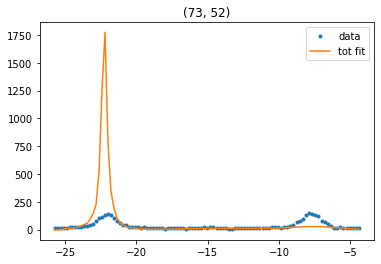

In [54]:
Plot_Elements_Spectrum(matrix, tau_not_bad[:10], fit = 'tot')

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


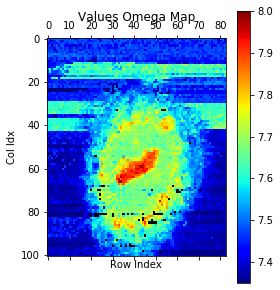

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


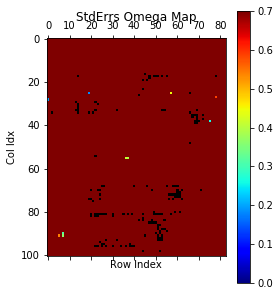

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


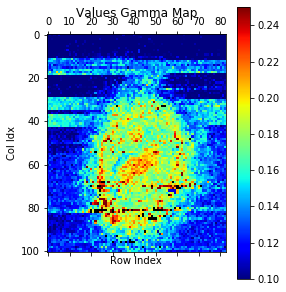

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


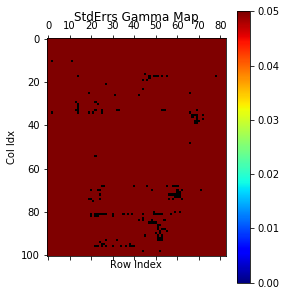

Completata Parameter_Map per tau
Ho trovato 66 elementi saturati


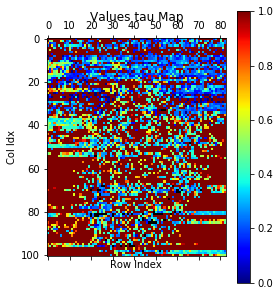

Completata Parameter_Map per tau
Ho trovato 66 elementi saturati


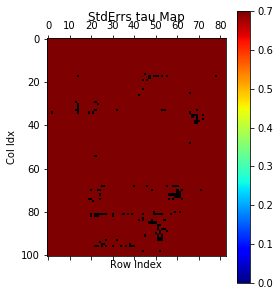

In [14]:
omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 8., fig = 'omega_tot_map', path=now_path)
Delta_omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,0.7, fig = 'Delta_omega_tot_map', path=now_path, Deltas = True)
gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.25, fig = 'Gamma_tot_map', path=now_path)
Delta_gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0,0.05, fig = 'Delta_gamma_tot_map', path=now_path, Deltas = True)
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0., 1., fig = 'tau_map', path=now_path)
Delta_tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0,0.7, fig = 'Delta_tau_map', path=now_path, Deltas = True)

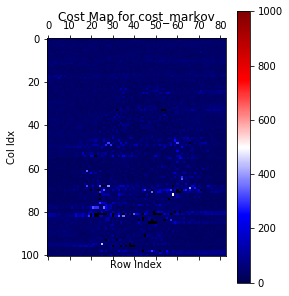

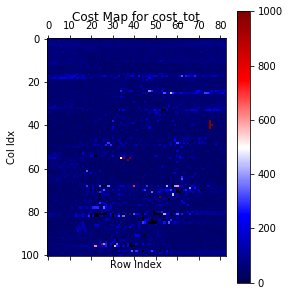

In [15]:
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)
tot_cost_map = Get_cost_map(matrix, 'tot', len(rows), len(cols), 'tot_cost_map', path = now_path)


In [17]:
tau_not_bad = []
for (ii,jj) in boni:
    if matrix[ii][jj].Tot_Fit_Params['tau']['StdErrs'] < matrix[ii][jj].Tot_Fit_Params['tau']['Values']:
        tau_not_bad.append((ii,jj))
        print(str((ii,jj)))
        

(40, 76)
(55, 35)
(56, 37)
(73, 52)


In [18]:
for (ii,jj) in tau_not_bad:
    print(str((ii,jj)), '\n', matrix[ii][jj].Tot_Fit_Params)

(40, 76) 
                 Co     Omega     Gamma      Delta       tau  delta_position  \
Values    0.121118  7.597234  0.140535  46.504229  0.352776       -1.306459   
StdErrs   0.006732  0.101374  0.136881   7.005520  0.055209        0.049083   
Initials  0.100932  7.673974  0.139143   0.139143  1.000000        1.497096   

          delta_width  delta_amplitude     shift     offset  
Values       1.927876         0.003110  3.178711 -29.951370  
StdErrs      0.024070         0.000049  0.049086   1.976993  
Initials     1.947349         0.003079  0.370169   9.345889  
(55, 35) 
                 Co     Omega     Gamma     Delta       tau  delta_position  \
Values    0.126977  7.841040  0.151596  1.329075  0.187231       -0.953126   
StdErrs   0.016183  0.533183  0.193697  1.079040  0.149536        0.024172   
Initials  0.105826  7.764344  0.152495  0.152495  1.000000       -1.092358   

          delta_width  delta_amplitude     shift      offset  
Values       2.285461         0.00044

In [19]:
matrix[73][52].Tot_Fit_Params

Co     Omega     Gamma      Delta       tau  delta_position  \
Values    0.122358  7.744938  0.177469  27.212238  0.156088        1.276562   
StdErrs   0.011103  0.751821  0.709926   4.589721  0.039931        0.296267   
Initials  0.101965  7.823169  0.175712   0.175712  1.000000        1.277469   

          delta_width  delta_amplitude     shift     offset  
Values       1.902392         0.001092  0.179457 -25.434519  
StdErrs      0.013211         0.000011  0.296266   2.212894  
Initials     1.921608         0.001081  0.175201   8.549241

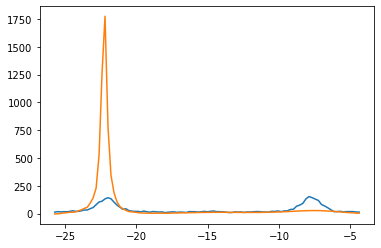

In [48]:
plot(matrix[73][52].x_freq, matrix[73][52].y)
plot(matrix[73][52].x_freq, matrix[73][52].y_fit)

In [21]:
matrix[73][52].Tot_Fit_Params

Co     Omega     Gamma      Delta       tau  delta_position  \
Values    0.122358  7.744938  0.177469  27.212238  0.156088        1.276562   
StdErrs   0.011103  0.751821  0.709926   4.589721  0.039931        0.296267   
Initials  0.101965  7.823169  0.175712   0.175712  1.000000        1.277469   

          delta_width  delta_amplitude     shift     offset  
Values       1.902392         0.001092  0.179457 -25.434519  
StdErrs      0.013211         0.000011  0.296266   2.212894  
Initials     1.921608         0.001081  0.175201   8.549241